In [1]:
from dicom_contour.contour import *

In [2]:
# example patient path
path = "C:/Users/Adwait/Desktop/Nanavati dataset/23/"

**FINDING THE CONTOUR FILE**

It is often the case that our patient data will be inside a directory as we linked above with 'path'. Inside that folder we will be having DICOM files for each slice from the MRI output as well as a single file with the contour information for that specific MRI sequence.

Function `get_contour_file` will give us the name of the contour file. This function will return the last contour file it sees. The usual case is that for a single patient there is a single contour file which has all the information for different contours or different ROI sequences. If there are multiple contour files a warning will be raised and you should probably take it into account before further analysis.  

In [3]:
def get_contour_file(path):
    """
    Get contour file from a given path by searching for ROIContourSequence 
    inside dicom data structure.
    More information on ROIContourSequence available here:
    http://dicom.nema.org/medical/dicom/2016c/output/chtml/part03/sect_C.8.8.6.html
    
    Inputs:
            path (str): path of the the directory that has DICOM files in it, e.g. folder of a single patient
    Return:
        contour_file (str): name of the file with the contour
    """
    # handle `/` missing
    if path[-1] != '/': path += '/'
    # get .dcm contour file
    fpaths = [path + f for f in os.listdir(path) if '.dcm' in f]
    n = 0
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if 'ROIContourSequence' in dir(f):
            contour_file = fpath.split('/')[-1]
            n += 1
    if n > 1: warnings.warn("There are multiple files, returning the last one!")
    return contour_file

In [4]:
# get the contour file for this patient
x=get_contour_file(path)

In [5]:
# let's create a copy of this contour file and see what happens
shutil.copyfile(path + x,
               path + '/contour_copy.dcm')

'C:/Users/Adwait/Desktop/Nanavati dataset/23//contour_copy.dcm'

In [6]:
# we now see a warning saying that 'There are multiple files, returning the last one!'
get_contour_file(path)

C:\Users\Adwait\AppData\Local\Temp\ipykernel_14640\2171419403.py:23: UserWarning: There are multiple files, returning the last one!
  if n > 1: warnings.warn("There are multiple files, returning the last one!")


'RS.1.2.246.352.221.550730217198029209312881507733394223293.dcm'

In [7]:
os.remove(path + '/contour_copy.dcm')

In [8]:
# let's store our dicom file for the rest of the introduction
contour_file = get_contour_file(path)

PATIENTXXX\
    
    image0.dcm
    image2.dcm
    image3.dcm
    ...
    imagez.dcm
    contour.dcm

**FINDING THE RIGHT CONTOUR SEQUENCE**

We now have a contour file, and this contour file will information embedded in an unstructured tree-like way. Below we can see this nested structure after reading this DICOM file using `read_file` from pydicom package. Parsing data out this unstructured data source is not as easy as it seems. Our goal here is to make everyone's lives easier by making this process relatively smooth. Some problems or things that make parsing are that: DICOM contour files might have multiple contour sequences, e.g. different contours from different experts, it is really hard to read DICOM documentation to find our way down in this tree-like data structure and it is very hard to look at it and understand, and also it is still possible to use OOP logic and find our way out but still it's kind of a waste of time.

We will step by step find all the images/slices of MRI that are associated with a contour sequence with just 2 functions.

In [9]:
contour_data = dicom.read_file(path + '/' + contour_file)

Step 1 is to list all the different contour sequences available for that patient, because we might want to a specific one for our application. Given a contour dataset `get_roi_names` will return a list of all available ROI sequence names that are available in our contour dataset.

In [10]:
get_roi_names(contour_data)

['Hippocampus_R', 'Hippocampus_L']

**MAPPING CONTOURS INTO NUMPY ARRAY**

For our application (deeplearning brain tumor segmentation), which I will be mentioning in a following blog post in detail, we are going to use 'RTV' sequence. As a next step we will use `cfile2pixels` which will take a filename with a path of directory containing the patient files, such we defined at the beginning, and an index for the ROIContourSeq which is 0 for 'RTV'. This function will then return image contour arrays in numpy.array format.

This part is quite magical and handy since all the contour information is embedded in catersian coordinate points (x,y,z) in mm. This function under the hood will map each (x,y,z) point to a pixel position while creating a binary array with 0s and 1s. Final output is a list of tuples having the associated image in numpy array, contour binary 2d array and that associated image id.

In [11]:
def cfile2pixels(file, path, ROIContourSeq=0):
    """
    Given a contour file and path of related images return pixel arrays for contours
    and their corresponding images.
    Inputs
        file: filename of contour
        path: path that has contour and image files
        ROIContourSeq: tells which sequence of contouring to use default 0 (RTV)
    Return
        contour_iamge_arrays: A list which have pairs of img_arr and contour_arr for a given contour file
    """
    # handle `/` missing
    if path[-1] != '/': path += '/'
    f = dicom.read_file(path + file)
    # index 0 means that we are getting RTV information
    Hippocampus = f.ROIContourSequence[ROIContourSeq]
    # get contour datasets in a list
    contours = [contour for contour in Hippocampus.ContourSequence]
    img_contour_arrays = [coord2pixels(cdata, path) for cdata in contours]
    return img_contour_arrays

In [12]:
# get all image-contour array pairs
contour_arrays = cfile2pixels(file=contour_file, path=path, ROIContourSeq=1)

In [13]:
contour_arrays[4]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int16),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int8),
 '1.2.246.352.221.50786127766561457202336075712373270177')

In [14]:
# get first image - contour array
first_image, first_contour, img_id = contour_arrays[4]

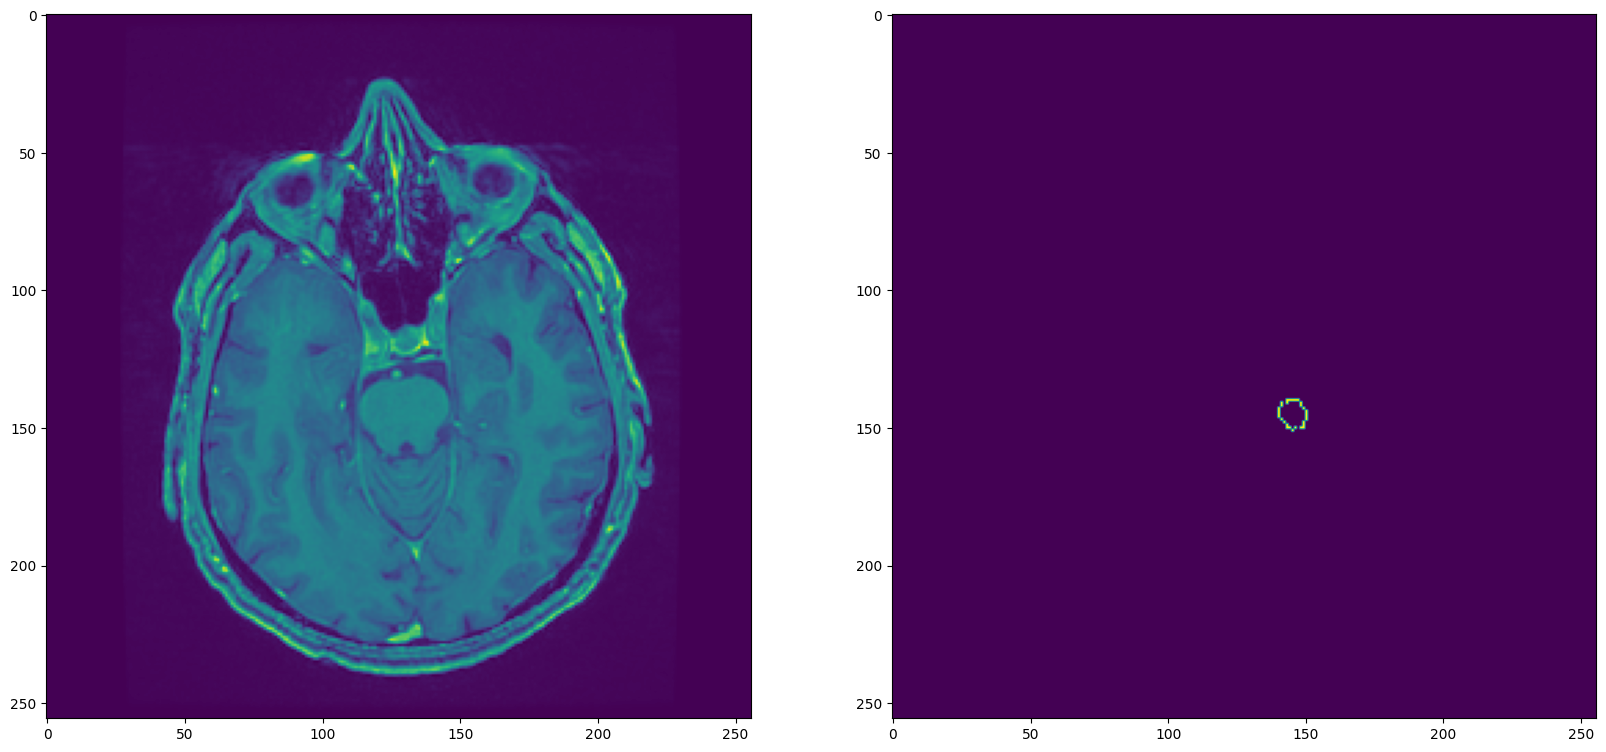

In [15]:
# show an example
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(first_image)
plt.subplot(1,2,2)
plt.imshow(first_contour)

Can you spot a problem in this image-contour pair? The problem is that our map from cartesian coordinates to pixel positions are imperfect due to numerical instabilities we have inside the DICOM files. The way we generate this map is done with  `coord2pixel` function, which takes a single contour DICOM dataset and returns an image-contour numpy array pair. This function extracts x_spacing and y_spacing which are the spacings between two adjacent pixels as well as the image origin which is the center upper left point. Then we calculate pixel positions with this formula:

`(np.ceil((y - origin_y) / y_spacing), np.ceil((x - origin_x) / x_spacing))`

The problem is that these numbers are not giving perfect integers but rather floating numbers like xxx.99 and xxx.49. This is our best estimate of the pixel position and after doing a ton of research online and asking experts, I found out that this was the common practice. But by the end we will see that this will not be an issue for our particular application and that we are interested in a far better representation, such as a mask.

**ORDERING THE IMAGES**

It is often important to get the right order of slices of a DICOM image especially when .dcm files for each slice might be arbitrarily ordered by name or inside the folder. For getting the slice orders right we will use `slice_order` function. This function will take a path that has DICOM files ,as we defined at the beginning, and then will return a list of tuples having filenames with right order. Output is a list of tuples (filename, z-position in mm). Getting the order is also very important if you are interested in working directly with 3d voxels, e.g. using 3D CNNs. I will go in depth about this in a following blog post. 

In [16]:
def slice_order(path):
    """
    Takes path of directory that has the DICOM images and returns
    a ordered list that has ordered filenames
    Inputs
        path: path that has .dcm images
    Returns
        ordered_slices: ordered tuples of filename and z-position
    """
    # handle `/` missing
    if path[-1] != '/': path += '/'
    slices = []
    for s in os.listdir(path):
        try:
            f = dicom.read_file(path + '/' + s)
            f.pixel_array  # to ensure not to read contour file
            slices.append(f)
        except:
            continue

    slice_dict = {s.SOPInstanceUID: s.ImagePositionPatient[-1] for s in slices}
    ordered_slices = sorted(slice_dict.items(), key=operator.itemgetter(1))
    return ordered_slices

In [17]:
# ordered files
ordered_slices = slice_order(path)
ordered_slices[:5]

[('1.2.246.352.221.48429758647851460754367430381778013866', '-67.2417'),
 ('1.2.246.352.221.541750579338519198312796368811783753128', '-66.6417'),
 ('1.2.246.352.221.51018005925273119228256056075198709660', '-66.0417'),
 ('1.2.246.352.221.480249135120432109716559472094143942321', '-65.4417'),
 ('1.2.246.352.221.57097180224338390708101687428625482684', '-64.8418')]

**GETTING CONTOUR DICTIONARY**

`get_contour_dict` function is wrapper around `cfile2pixels` function which will return a dictionary. Eventhough this is not often used by itself, it is called by `get_data` while generating the ordered image-contour array pairs in order. It takes contour file and path of the folder containing .dcm files as well as the desired ROISequence index that we mentioned before and will return a dictionary of image filenames that are associated with a contour as keys and image-contour array pair as values.

In [18]:
contour_dict = get_contour_dict(contour_file, path, 1)

**COMBINING ALL**

This is probably the function we desire the most, this function will take a path as usual and the index of desired ROISequence which is 0 for 'RTV'. Then `get_data` will return a 3d array of images and corresponding 3d contours. In our case we have 120 slices with 512x512 resolution.

In [19]:
def get_data(path, index):
    """
    Generate image array and contour array
    Inputs:
        path (str): path of the the directory that has DICOM files in it
        contour_dict (dict): dictionary created by get_contour_dict
        index (int): index of the desired ROISequence
    Returns:
        images and contours np.arrays
    """
    images = []
    contours = []
    # handle `/` missing
    if path[-1] != '/': path += '/'
    # get contour file
    contour_file = get_contour_file(path)
    # get slice orders
    ordered_slices = slice_order(path)
    # get contour dict
    contour_dict = get_contour_dict(contour_file, path, index)

    for k,v in ordered_slices:
        # get data from contour dict
        if k in contour_dict:
            images.append(contour_dict[k][0])
            contours.append(contour_dict[k][1])
        # get data from dicom.read_file
        else:
            img_arr = dicom.read_file(path + k + '.dcm').pixel_array
            contour_arr = np.zeros_like(img_arr)
            images.append(img_arr)
            contours.append(contour_arr)

    return np.array(images), np.array(contours)

In [20]:
images, contours = get_data(path, index=1)

In [21]:
images.shape, contours.shape

((332, 256, 256), (332, 256, 256))

**SHOWING IMAGES AND CONTOURS**

After reading images and contours in numpy array format we might like to plot/show these images. For this purpose we may use `plot2dcontour`. This function takes a single image array and contour array as input and shows the actual image and its pair it's contour side by side.

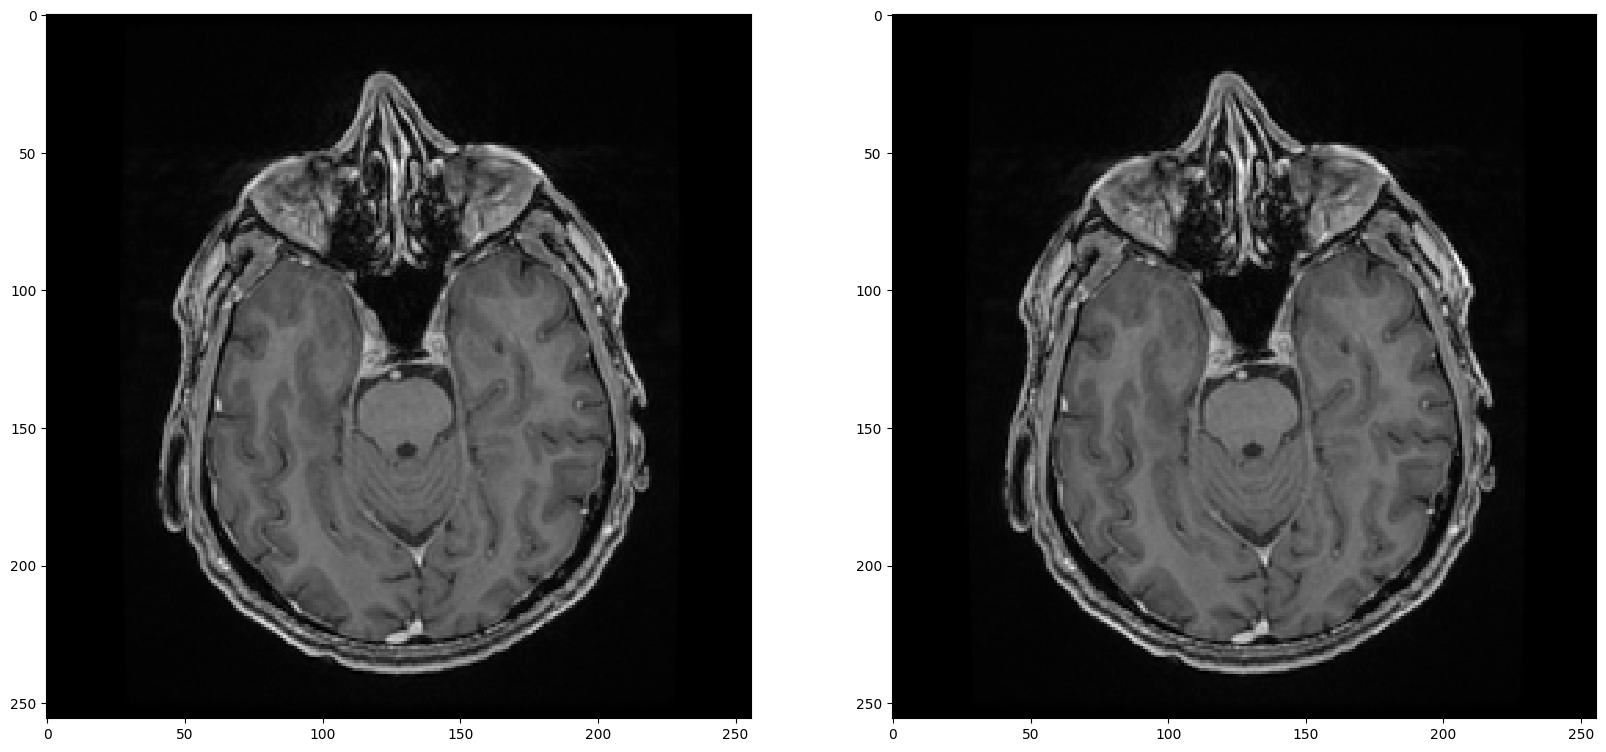

In [22]:
for img_arr, contour_arr in zip(images[107:108], contours[107:108]):
    plot2dcontour(img_arr, contour_arr)

**FILLING CONTOUR ARRAYS**

So far we were able to read images and contours successfully with a single `get_data` function. But it is often the case, especially for deep learning applications such as semantic segmentation we are interested in pixel labels, e.g. tumor and not tumor (1, 0). But with contours we only have the surrounding pixels denoted as 1. So we need to actually fill this contour in a way it will give us a mask. For this purpose we will use `fill_contour` function. This function will take a contour numpy.array and fill it.

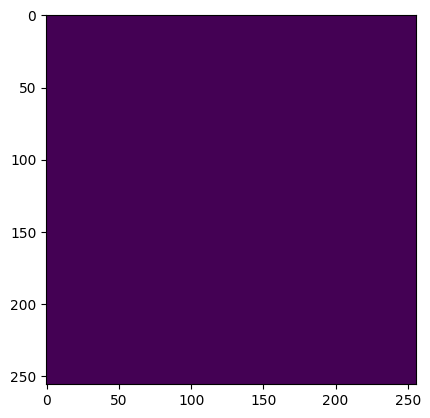

In [23]:
cntr = contours[107]
plt.imshow(cntr)

In [24]:
#filled_cntr = fill_contour(cntr)
#plt.imshow(filled_cntr)

**CREATING IMAGE MASK DIRECTORIES**

I believe this part will be very exciting for deeplearning pracitioners like me. Most of th libraries these days require images to be under some folder and thus many people store their data under labeled folders like:

    /cat

        cat0 
        cat1
        ...
   
We can't exactly have this same structure but we can have an adjusted one for our own case. The function `create_image_mask_files` will as we did in `get_data` take a folder path of DICOM files and the index of desired ROISequence to create '.png' files for both images and contours. Naming convention is like image_{i} and mask_{i}, where i is the index of ordered slices. This will give us the following structure:

    /parent dir of path

        /images
            image0
            image1
            ...

        /masks
            mask0
            mask1
            ...

Now we can easily write a dataset and dataloader class and easily grab our input and output tensors for our own deeplearning application.

In [25]:
def create_image_mask_files(path, index, img_format='png'):
    """
    Create image and corresponding mask files under to folders '/images' and '/masks'
    in the parent directory of path.
    
    Inputs:
        path (str): path of the the directory that has DICOM files in it, e.g. folder of a single patient
        index (int): index of the desired ROISequence
        img_format (str): image format to save by, png by default
    """
    # Extract Arrays from DICOM
    X, Y = get_data(path, index)
    Y = np.array([fill_contour(y) if y.max() == 1 else y for y in Y])

    # Create images and masks folders
    
    os.makedirs(path + '/images_R/', exist_ok=True)
    os.makedirs(path + '/masks_R/', exist_ok=True)
    for i in range(len(X)):
        plt.imsave(path + f'/images_R/image_{i}.{img_format}', X[i, :, :])
        plt.imsave(path + f'/masks_R/mask_{i}.{img_format}', Y[i, :, :])

In [26]:
create_image_mask_files(path, 1, img_format='jpg')